<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab4/blob/main/CU/Lab4_Curie_heat_capacity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0 as mu0
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.integrate import cumulative_trapezoid as cumtrapz


/tmp/ipython-input-3496286431.py:21: RuntimeWarning: overflow encountered in multiply
  return Tenv + (T0 - Tenv) * np.exp(-k * (time - t0))


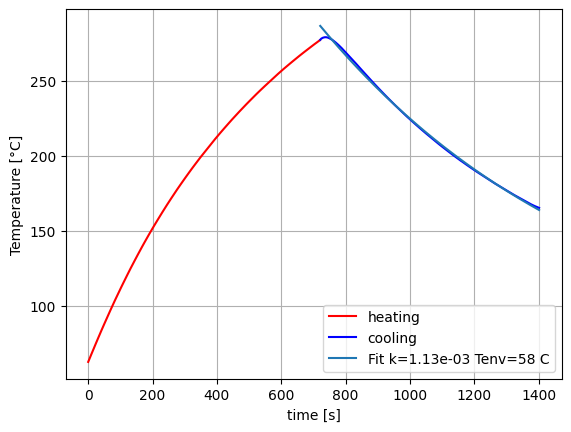

In [79]:
url = 'https://raw.githubusercontent.com/tphlabs/data/refs/heads/main/Lab4_Curie/2025.09/11_2.csv'
temp, V1, V2, phi, V, I = np.loadtxt(url, delimiter=',', skiprows=60, usecols=[1,2,3,4,5,6], unpack=True)
time = np.arange(V1.size)

# skip 1st 10 seconbds
#time = time_[time_>10]
#temp = temp[time_>10]

# timeline
# timeline
heating = I > 0
cooling = I == 0
t0 = np.max(time[heating])
P = V * I

plt.grid()
plt.ylabel('Temperature [°C]')
plt.xlabel('time [s]')

def cooling_law(time, k, T0, Tenv):
  return Tenv + (T0 - Tenv) * np.exp(-k * (time - t0))


initial = [0.5, 170+273, 300]
parameters, _ = curve_fit(cooling_law, time[cooling], temp[cooling], p0=initial)
temp_expected =  cooling_law(time[cooling], *parameters)
k = parameters[0]
Tenv = parameters[2]
plt.plot(time[heating], temp[heating],  label='heating', color='red')
plt.plot(time[cooling], temp[cooling],  label='cooling',  color='blue')
plt.plot(time[cooling], temp_expected, label=f'Fit k={k:.2e} Tenv={Tenv:.0f} C')
plt.legend()

(1.0, 1.5)

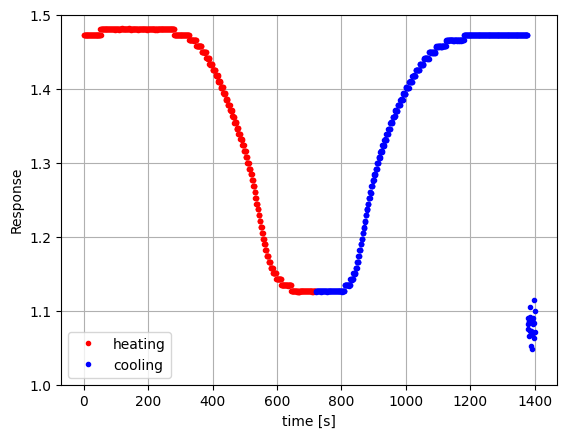

In [80]:
response = V2 / V1
plt.plot(time[heating], response[heating], '.', color='red', label='heating')
plt.plot(time[cooling], response[cooling], '.', color='blue', label='cooling')
plt.legend()
plt.grid()
plt.xlabel('time [s]')
plt.ylabel('Response')
plt.ylim(1, 1.5)

In [81]:
def survival_function(x, height, loc, sigma, offset):
    return height * norm.sf(x, loc, sigma) + offset

def smooth(signal, window_size=20):
  # Create the kernel for a simple moving average
  # Each element in the window gets a weight of 1/window_size
  kernel = np.ones(window_size) / window_size
  # Perform the convolution
  smoothed_signal = np.convolve(signal, kernel, mode='same')
  return smoothed_signal

Tc = 237 +- 19 C


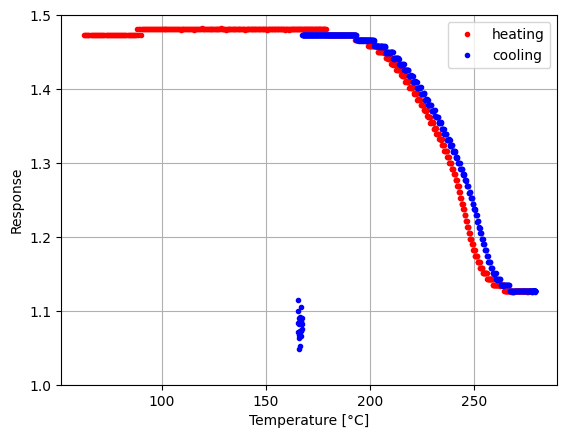

In [82]:
plt.plot(temp[heating], response[heating], '.', color='red', label='heating')
plt.plot(temp[cooling], response[cooling], '.', color='blue', label='cooling')
plt.legend()
plt.xlabel('Temperature [°C]')
plt.ylabel('Response')
plt.ylim(1, 1.5)
plt.grid()

temp_c = temp[heating]
response_c = response[heating]

# Fit the heating curve

height = np.max(response) - np.min(response)
offset = np.min(response)
sigma = 10
loc = np.max(temp) - sigma
initial = [height, loc, sigma, offset]

# Fit the cooling curve
popt,  _ = curve_fit(survival_function, temp_c, response_c, p0=initial)


Tc, Tc_sigma = popt[1], popt[2]
print(f'Tc = {Tc:.0f} +- {Tc_sigma:.0f} C')
transition = (temp > Tc - 2*Tc_sigma) & (temp < Tc + 2* Tc_sigma)
#plt.plot(temp[transition], response[transition], '.', color='gray', label='transition')

At cooling
$$
\dot T_{cooling} = -k (T - T_{env})
$$
We find parameters $k$ and $T_{env}$ by fitting cooling part $T(t)$ data.

At heating assuming that there is no cooling
$$
\dot T_{heating} = \frac{\dot Q}{C} = \frac{P}{C}, \quad P = I\cdot V
$$
where $Q(t) = \int P \, dt $ - heating energy, $P = I V$ - heating power, $T$ - core temperature, $C$ - core heat capacity.

Total temperature change is explained by heating and cooling
$$
\dot T = \dot T_{heating} + \dot T_{cooling} = \frac{P}{C} - k (T - T_{env})
$$

Therefore
$$
C = \frac{P}{\dot T  +k (T - T_{env})}
$$

On the other hand, heat capacity $C$ of the system `oven` $+$ `core` is
$$
C = m_{oven}  c_{oven} + m_{core}  c_{core}
$$
where $m_{}$ and $c_{x}$ is respective mass and heat capacity per unit mass.

Text(0, 0.5, '$\\dot T$ [K/s]')

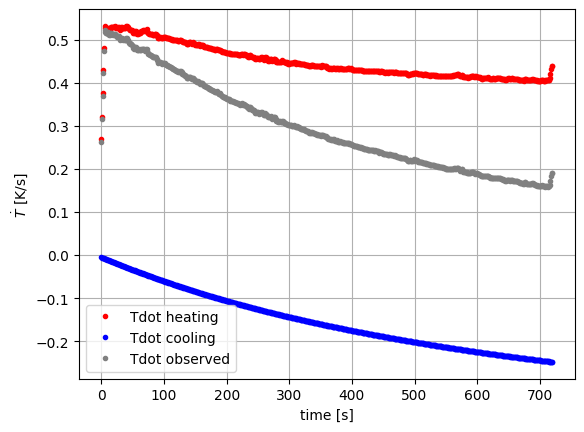

In [83]:
tdot = smooth(np.gradient(temp, time), window_size=10)
tdot_cooling = -k * (temp - Tenv)
tdot_heating = tdot - tdot_cooling
plt.plot(time[heating] , tdot_heating[heating], '.', color='red', label='Tdot heating')
plt.plot(time[heating] , tdot_cooling[heating], '.', color='blue', label='Tdot cooling')
plt.plot(time[heating] , tdot[heating], '.', color='gray', label='Tdot observed')
plt.legend()
plt.grid()
plt.xlabel('time [s]')
plt.ylabel(r'$\dot T$ [K/s]')
#plt.plot(P[heating] /tdot_heating[heating], '.')
#plt.xlim(500, 1000)
#plt.ylim(0, 100)

Text(0, 0.5, '$\\dot T$ [K/s]')

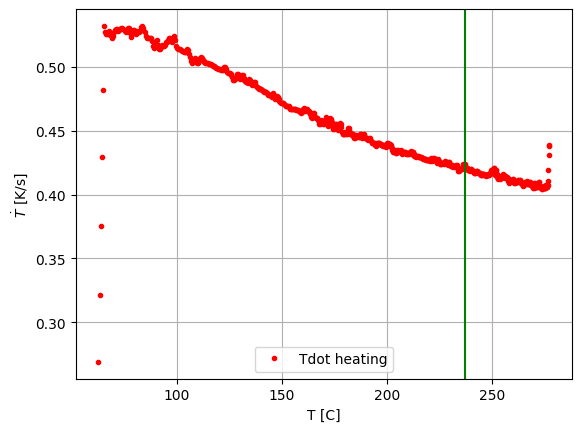

In [84]:
plt.plot(temp[heating] , tdot_heating[heating], '.', color='red', label='Tdot heating')
plt.legend()
plt.grid()
plt.axvline(Tc, color='green')
plt.xlabel('T [C]')
plt.ylabel(r'$\dot T$ [K/s]')

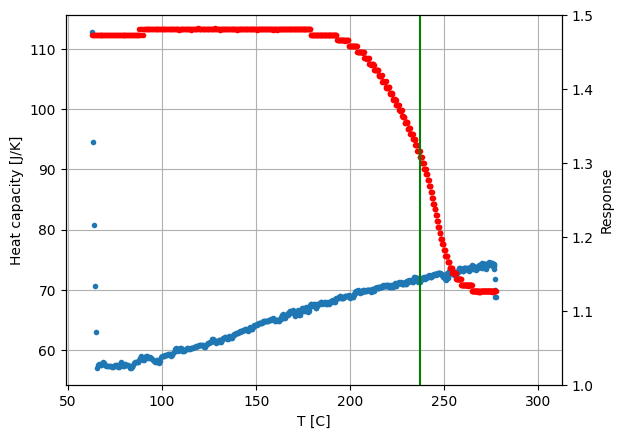

In [85]:
fig, ax = plt.subplots()
C = P[heating] / tdot_heating[heating]
ax.plot(temp[heating], C, '.')
ax.grid()
ax.set_xlabel('T [C]')
ax.set_ylabel('Heat capacity [J/K]')
ax.set_xlim(Tc - 10*Tc_sigma, Tc + 4*Tc_sigma)
#ax.set_ylim(50,62)

ax1 = ax.twinx()
ax1.plot(temp[heating], response[heating], 'r.')
ax1.set_ylabel('Response')
ax1.set_ylim(1.0, 1.5)
ax1.axvline(Tc, color='green')

In [43]:
m_oven = 70e-3
m_sample = 36e-3
m = m_oven + m_sample
c = C / m
print(np.mean(c), np.std(c))

561.8066087308727 51.432579826220966


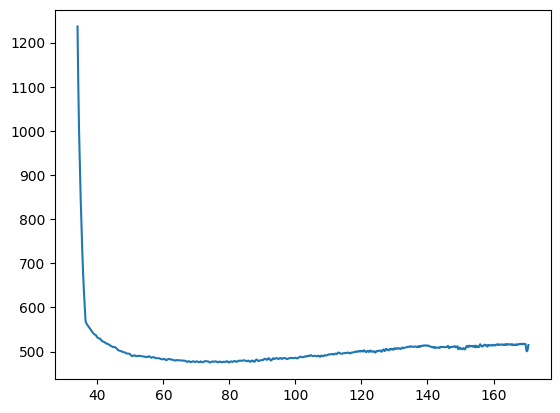

In [15]:
plt.plot(temp[heating], c)